<a href="https://colab.research.google.com/github/nafis-momeni/BioRED_LLM/blob/main/biored_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from collections import defaultdict
# type_f = "id_selected"
# shot_f = "20_shots"
# root_path = "/content/drive/MyDrive/BioRE/data"
# pred_path = root_path + f"/{type_f}/preds/pred_{shot_f}.txt"
# actual_path = "/content/drive/MyDrive/BioRE/data/expected.txt"

# result_path = root_path +  f"/{type_f}/{shot_f}_results.txt"
# figure_path = root_path +  f"/{type_f}/{shot_f}_confusion_matrix.png"

pred_path = "/content/10_shots_represent_samples.txt"
actual_path = "/content/expected.txt"

name_eval = "10 Shots Representative Samplse"
result_path = "/content/10_shots_represent_samples.txt"
figure_path = "/content/10_shots_represent_samples.png"
ex = []

In [3]:
#global attr

types = ['Association', 'Comparison', 'Conversion', 'Cotreatment', 'Negative_Correlation', 'Positive_Correlation', 'Bind', 'Drug_Interaction']

ent_pair_tp, ent_pair_fp, ent_pair_fn = 0, 0, 0
novelty_tp, novelty_fp, novelty_fn, novelty_tn = 0, 0, 0, 0
total_p, total_n = 0, 0
rel_confusion_matrix = defaultdict(lambda: defaultdict(int))




In [4]:
def parse_output(file_path, pairs_only):
    data = defaultdict(list)
    dup =0
    all_rels = 0
    unique_rels = 0
    with open(file_path, 'r') as file:
        content = file.read()
        results = content.split('\n\n')
        for result in results:
          #try pmid=parlines[0].split(':')[1]
          lines = result.strip().split('\n')
          try:
            pmid = lines[0].split(':')[1].strip(' ')
          except:
            print(lines)
            break
          for line in lines[1:]:
            parts = line.split(',')
            all_rels+=1
            if pairs_only:
              relation = tuple(sorted(parts))
              if relation not in data[pmid]:
                data[pmid].append(relation)
                unique_rels +=1
              else:
                # print("duplication: "+ line + '\n')
                dup+=1
            else:
              if parts[0] not in types:
                print("incorrectformat:" ,str(parts[0]),lines)
              else:
                try:
                  relation = (parts[0], *sorted(parts[1:3]), parts[3])
                  if relation not in data[pmid]:
                    data[pmid].append(relation)
                    unique_rels +=1
                  else:
                    dup+=1
                except:
                 print("incorrectformat:" ,parts)

    print(dup, unique_rels, all_rels)
    return data
def novelty(actual_data, pred_data, entp):
  global novelty_tp, novelty_fn, novelty_fp, novelty_tn
  actual_novelty = [r[3] for r in actual_data if tuple(sorted(r[1:3])) == tuple(sorted(entp))][0]
  pred_novelty = [r[3] for r in pred_data if tuple(sorted(r[1:3])) == tuple(sorted(entp))][0]
  #todo tn???
  if actual_novelty == 'Novel' and pred_novelty == 'Novel':
    novelty_tp +=1
  if actual_novelty == 'Novel' and pred_novelty == 'No':
    novelty_fn +=1
  if actual_novelty == 'No' and pred_novelty == 'Novel':
    novelty_fp +=1
  if actual_novelty == 'No' and pred_novelty == 'No':
    novelty_tn +=1

def precision_func(tp, fp, fn):
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  return precision
def recall_func(tp,fp,fn):
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  return recall
def f1_score_func(precision, recall):
  fscore = 2 * (recall * precision)/(recall + precision) if (recall + precision) > 0 else 0
  return fscore
def accuracy_func(tp,fp,fn,tn):
  acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
  return acc

In [5]:
pairs_only = False

pred_data = parse_output(pred_path,pairs_only)
actual_data = parse_output(actual_path,pairs_only)

['']
17 1427 1444
['']
0 1163 1163


In [6]:
print(len(pred_data))
print(len(actual_data))

100
100


In [7]:
# print(pred_data)

In [8]:
from collections import Counter
if not pairs_only:
  n =0
  for pmid in actual_data:
    if pmid in pred_data:
      pred_ent_pairs = [tuple(sorted(pr[1:3])) for pr in pred_data[pmid]]
      pair_counts = Counter(pred_ent_pairs)
      repeated_pairs = [pair for pair, count in pair_counts.items() if count > 1]
      for pair, count in pair_counts.items():
        if count > 1:
          n+= count
      rels = [r for r in pred_data[pmid] if tuple(sorted(r[1:3])) in repeated_pairs]
      if len(repeated_pairs) > 0:
        print(pmid, rels)
        unique_pairs = [pair for pair, count in pair_counts.items() if count == 1]
        unique_relations = [r for r in pred_data[pmid] if tuple(sorted(r[1:3])) in unique_pairs]
        pred_data[pmid] = unique_relations
  print(n)

0


In [9]:
ent_pair_tp, ent_pair_fp, ent_pair_fn = 0, 0, 0
novelty_tp, novelty_fp, novelty_fn, novelty_tn = 0, 0, 0, 0
total_p, total_n = 0, 0
rel_confusion_matrix = defaultdict(lambda: defaultdict(int))
no_doc=0

# pairs_only = True

if pairs_only:
  for pmid in actual_data:
    if pmid in pred_data:
      for entp in actual_data[pmid]:
        if entp in pred_data[pmid]:
          ent_pair_tp+=1
        else:
          ent_pair_fn+=1
      for entp in pred_data[pmid]:
        if entp not in actual_data[pmid]:
          ent_pair_fp+=1

    else:
      print("no match for: "+ pmid)
      no_doc += len(actual_data[pmid])
else:
  for pmid in actual_data:
    if pmid in pred_data:
      actual_ent_pairs = [tuple(sorted(ar[1:3])) for ar in actual_data[pmid]]
      pred_ent_pairs = [tuple(sorted(pr[1:3])) for pr in pred_data[pmid]]

      for entp in actual_ent_pairs:
        actual_type = [r[0] for r in actual_data[pmid] if tuple(sorted(r[1:3])) == tuple(sorted(entp))][0]
        if entp in pred_ent_pairs:
          ent_pair_tp+=1
          pred_type = [r[0] for r in pred_data[pmid]  if tuple(sorted(r[1:3])) == tuple(sorted(entp))][0]

          if pred_type in types :
            rel_confusion_matrix[actual_type][pred_type] += 1
          else:
            print("wrong format", pred_type)

          novelty(actual_data[pmid], pred_data[pmid], entp)

        else:
          ent_pair_fn+=1
          rel_confusion_matrix[actual_type]['NA'] += 1

      for entp in pred_ent_pairs:
        if entp not in actual_ent_pairs:
          ent_pair_fp+=1
      for r in actual_data[pmid]:
        if r in pred_data[pmid]:
          total_p +=1
        else:
          total_n +=1
    else:
      print("no match for: "+ pmid)
      no_doc += len(actual_data[pmid])


In [10]:
if pairs_only:
  tp = ent_pair_tp
  fn = ent_pair_fn
  fp = ent_pair_fp
  precision = precision_func(tp,fp,fn)
  recall = recall_func(tp,fp,fn)
  f1_score = f1_score_func(precision, recall)

  print(f"entity pairs:")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1_score:.4f}")
  print(tp, fp, fn, '\n')
  print("considering blocked doc an FN")
  print("blocked doc pairs count: ",no_doc)
  fn = ent_pair_fn + no_doc
  precision = precision_func(tp,fp,fn)
  recall = recall_func(tp,fp,fn)
  f1_score = f1_score_func(precision, recall)

  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1_score:.4f}")
  print(tp, fp, fn)

#results

In [11]:
f_results = ""

In [12]:
tp = total_p
fn = total_n
fp = ent_pair_fp
precision = precision_func(tp,fp,fn)
recall = recall_func(tp,fp,fn)

f1_score = f1_score_func(precision, recall)

results = ""
results += f"total tp: {total_p}\n"
results += f"total fn: {total_n}\n"
results += f"total fp: {ent_pair_fp}\n"
results += f"Precision: {precision:.4f}\n"
results += f"Recall1: {recall:.4f}\n"
results += f"F1-score: {f1_score:.4f}\n\n"

# ex.append(round(precision, 4))
# ex.append(round(recall, 4))
ex.append(round(f1_score*100, 2))
# ex.append(total_p)
# ex.append(ent_pair_fp)
# ex.append(total_n)
f_results += results
print(results)

total tp: 310
total fn: 853
total fp: 811
Precision: 0.2765
Recall1: 0.2666
F1-score: 0.2715




In [13]:
precision = precision_func(tp=ent_pair_tp, fp =ent_pair_fp, fn = ent_pair_fn)
recall = recall_func(tp=ent_pair_tp, fp =ent_pair_fp, fn = ent_pair_fn)
f1_score = f1_score_func(precision, recall)

results = ""
results += "entity pairs:" + '\n'
results += f"Precision: {precision:.4f} \n"
results += f"Recall: {recall:.4f} \n"
results += f"F1-score: {f1_score:.4f} \n"
results += "(tp, fp, fn) \n"
results += f"{ent_pair_tp} {ent_pair_fp} {ent_pair_fn} \n\n"
f_results += results
print(results)

# ex.append(round(precision, 4))
# ex.append(round(recall, 4))
ex.append(round(f1_score*100, 2))
# ex.append(ent_pair_tp)
# ex.append(ent_pair_fp)
# ex.append(ent_pair_fn)


entity pairs:
Precision: 0.4317 
Recall: 0.5297 
F1-score: 0.4757 
(tp, fp, fn) 
616 811 547 




In [14]:
tp = novelty_tp
fp = novelty_fp
fn = novelty_fn
tn = novelty_tn
precision = precision_func(tp,fp,fn)
recall1 = recall_func(tp,fp,fn)
recall2 = recall_func(tp+tn,fp,fn)
f1_score = f1_score_func(precision, recall1)
acc = accuracy_func(tp,fp,fn,tn)
results = ""
results += f"Novelty:\n"
results += f"Precision: {precision:.4f}\n"
results += f"Recall1: {recall1:.4f}\n"
results += f"Recall2 tp +=tn: {recall2:.4f}\n"
results += f"F1-score: {f1_score:.4f}\n"
results += f"Accuracy: {acc:.4f}\n"
results += "(tp, fp, fn, tn) \n"
results += f"{tp} {fp} {fn} {tn} \n\n"
f_results += results
print(results)

# ex.append(round(precision, 4))
# ex.append(round(recall, 4))
ex.append(round(f1_score*100, 2))
# ex.append(round(acc, 4))
# ex.append(tp)
# ex.append(fp)
# ex.append(fn)
# ex.append(tn)


Novelty:
Precision: 0.8811
Recall1: 0.7707
Recall2 tp +=tn: 0.8095
F1-score: 0.8222
Accuracy: 0.7451
(tp, fp, fn, tn) 
363 49 108 96 




In [15]:
# Initialize variables for micro average
micro_tp = 0
micro_fp = 0
micro_fn = 0

# Initialize variables for macro average
macro_precisions = []
macro_recalls = []
macro_f1_scores = []
results = ""

for expected_class in types:
    tp = rel_confusion_matrix[expected_class][expected_class]
    fp = sum(rel_confusion_matrix[other_class][expected_class] for other_class in types if other_class != expected_class)
    fn = sum(rel_confusion_matrix[expected_class][other_class] for other_class in types  if other_class != expected_class)

    # Update micro average values
    micro_tp += tp
    micro_fp += fp
    micro_fn += fn

    # Calculate precision, recall, and F1-score for the current class
    precision = precision_func(tp,fp,fn)
    recall = recall_func(tp,fp,fn)
    f1_score = f1_score_func(precision, recall)

    results += f"Class {expected_class}:\n"
    results += f"Precision: {precision:.4f}\n"
    results += f"Recall: {recall:.4f}\n"
    results += f"F1-score: {f1_score:.4f}\n"
    results += "(tp, fp, fn) \n"
    results += f"{tp} {fp} {fn} \n\n"


    # Append to lists for macro average
    macro_precisions.append(precision)
    macro_recalls.append(recall)
    macro_f1_scores.append(f1_score)

# Calculate micro average
micro_precision = precision_func(micro_tp,micro_fp,micro_fn)
micro_recall = recall_func(micro_tp,micro_fp,micro_fn)
micro_f1_score = f1_score_func(micro_precision, micro_recall)


# Calculate macro average
macro_precision = sum(macro_precisions) / len(macro_precisions)
macro_recall = sum(macro_recalls) / len(macro_recalls)
macro_f1_score = sum(macro_f1_scores) / len(macro_f1_scores)

results += "Micro Averages:\n"
results += f"Precision: {micro_precision:.4f}\n"
results += f"Recall: {micro_recall:.4f}\n"
results += f"F1-score: {micro_f1_score:.4f}\n"
results += "(tp, fp, fn) \n"
results += f"{micro_tp} {micro_fp} {micro_fn} \n"

results += "\nMacro Averages:\n"
results += f"Precision: {macro_precision:.4f}\n"
results += f"Recall: {macro_recall:.4f}\n"
results += f"F1-score: {macro_f1_score:.4f}\n"


f_results += results

# print(results)

# ex.append(round(micro_precision, 4))
# ex.append(round(micro_recall, 4))
ex.append(round(micro_f1_score*100, 2))

# ex.append(micro_tp)
# ex.append(micro_fp)
# ex.append(micro_fn)

# ex.append(round(macro_precision, 4))
# ex.append(round(macro_recall, 4))
# ex.append(round(macro_f1_score, 4))

In [16]:

with open(result_path, 'w') as f:
  f.write(f_results)

In [17]:
print(ex)

[27.15, 47.57, 82.22, 63.64]


<ipython-input-18-b7950ada283c>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('BuPu', 8)


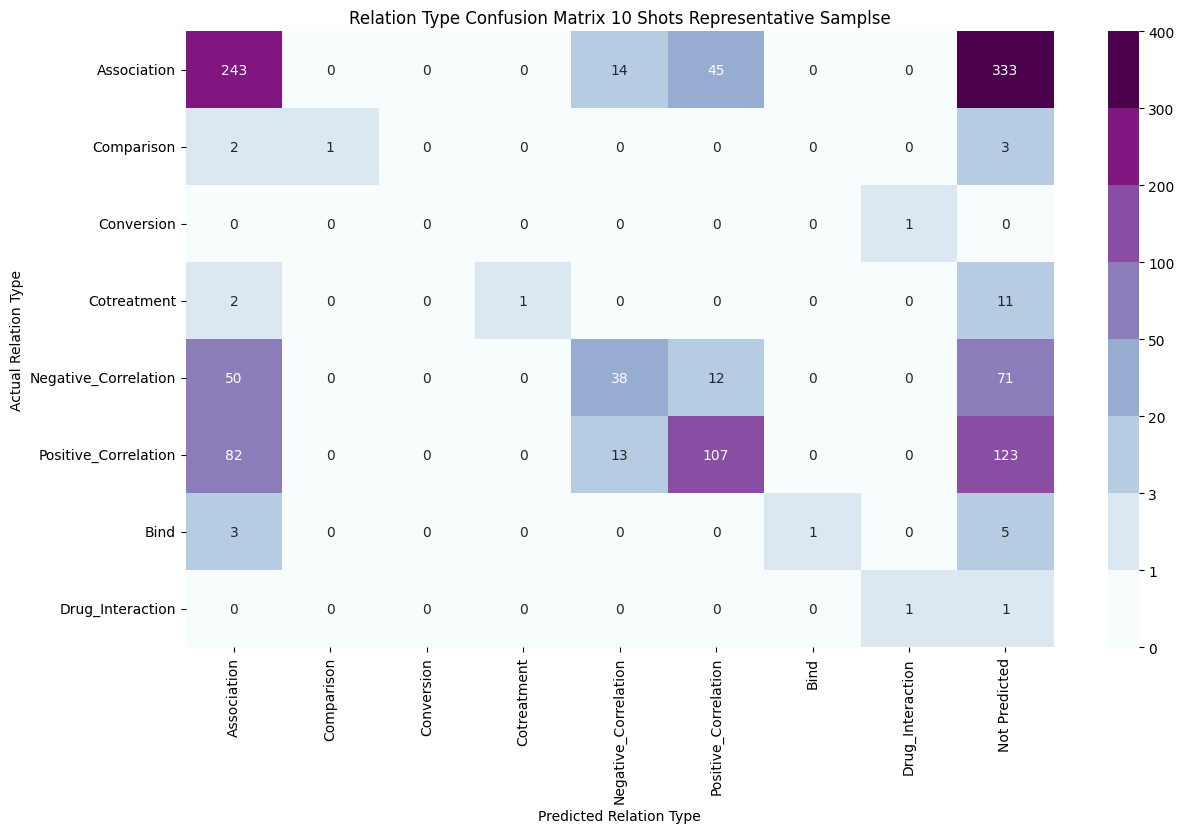

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

# Assuming types is a list of all unique relation types
# types = list(rel_confusion_matrix.keys())

# Create a 2D array to store the confusion matrix values
confusion_matrix_values = [[rel_confusion_matrix[actual_class][pred_class] for pred_class in types + ['NA']] for actual_class in types]

# Define custom color map
cmap = plt.cm.get_cmap('BuPu', 8)
cmap_colors = cmap(np.linspace(0, 1, 6))
cmap_colors[0] = [1, 1, 1, 1]  # Set the first color to white

# Create a custom normalization function
bounds = [0, 1, 3, 20, 50, 100, 200, 300, 400]
norm = colors.BoundaryNorm(bounds, ncolors=cmap.N)

# Draw the confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(confusion_matrix_values, annot=True, fmt="d", xticklabels=types + ['Not Predicted'], yticklabels=types, cmap=cmap, norm=norm)
plt.xlabel("Predicted Relation Type")
plt.ylabel("Actual Relation Type")
plt.title("Relation Type Confusion Matrix "+ name_eval)
# plt.savefig("/content/fig.png", dpi=300, bbox_inches="tight")
plt.savefig(figure_path, dpi=300, bbox_inches="tight")
plt.show()

#test

In [19]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd


# data = {
#     'Model': ['PubMedBERT', 'Mean of teams', 'Median of teams', 'GPT 3.5', 'GPT 4', 'Gemini 1.0 Pro'],
#     'Entity Pair': [74.29, 67.03, 73.56, 37.44, 42.93, 52.55],
#     'Entity Pair + Relation Type': [51.93, 47.74, 53.17, 13.41, 20.85, 42.82],
#     'Entity Pair + Novelty': [56.25, 47.74, 56.45, 22.83, 30.4, 89.59],
#     'Entity Pair + Relation Type + Novelty': [38.9, 35.22, 40.73, 8.7, 15.44, 14.9]
# }

# df = pd.DataFrame(data)

# sns.set(style="whitegrid")

# # custom_palette = ["#FF5733", "#3498DB", "#27AE60", "#F1C40F"]
# c = sns.color_palette("hls", 8)

# # Create a bar plot for each variable using the custom palette
# for col in df.columns[1:]:
#     plt.figure(figsize=(8, 6))
#     sns.barplot(y=col, data=df, palette=c, hue='Model')  # Specify the custom palette here
#     plt.xlabel(f'{col}')

#     # Add numbers on top of the bars
#     for p in plt.gca().patches:
#         plt.gca().annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height() + 1),
#                            ha='center', va='center', fontsize=10, color='black')

#     plt.show()


In [20]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Data
# models = ['PubMedBERT', 'Mean of teams', 'Median of teams', 'GPT 3.5', 'GPT 4', 'Gemini 1.0 Pro']
# entity_pair = [74.29, 67.03, 73.56, 37.44, 42.93, 52.55]
# entity_pair_relation_type = [51.93, 47.74, 53.17, 13.41, 20.85, 42.82]
# entity_pair_novelty_label = [56.25, 47.74, 56.45, 22.83, 30.4, 89.59]
# entity_pair_relation_type_novelty_label = [38.9, 35.22, 40.73, 8.7, 15.44, 14.9]

# # Set up the figure and axis
# fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# axs = axs.ravel()

# # Create bar plots
# axs[0].bar(models, entity_pair)
# axs[0].set_title('Entity Pair')
# axs[0].set_xlabel('Models')
# axs[0].set_ylabel('Score')

# axs[1].bar(models, entity_pair_relation_type)
# axs[1].set_title('Entity Pair + Relation Type')
# axs[1].set_xlabel('Models')
# axs[1].set_ylabel('Score')

# axs[2].bar(models, entity_pair_novelty_label)
# axs[2].set_title('Entity Pair + Novelty Label')
# axs[2].set_xlabel('Models')
# axs[2].set_ylabel('Score')

# axs[3].bar(models, entity_pair_relation_type_novelty_label)
# axs[3].set_title('Entity Pair + Relation Type + Novelty Label')
# axs[3].set_xlabel('Models')
# axs[3].set_ylabel('Score')

# # Adjust spacing between subplots
# plt.subplots_adjust(hspace=0.5, wspace=0.5)

# # Display the plot
# plt.show()

In [21]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Data
# models = ['PubMedBERT', 'Mean of teams', 'Median of teams', 'GPT 3.5', 'GPT 4', 'Gemini 1.0 Pro']
# entity_pair = [74.29, 67.03, 73.56, 37.44, 42.93, 52.55]
# entity_pair_relation_type = [51.93, 47.74, 53.17, 13.41, 20.85, 42.82]
# entity_pair_novelty_label = [56.25, 47.74, 56.45, 22.83, 30.4, 89.59]
# entity_pair_relation_type_novelty_label = [38.9, 35.22, 40.73, 8.7, 15.44, 14.9]

# # Set up the figure and axis
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
# fig.suptitle('Bar Plots', fontsize=16)

# # Plot the bar plots
# bar_width = 0.5
# index = np.arange(len(models))

# ax1.bar(index, entity_pair, bar_width)
# ax1.set_xlabel('Models')
# ax1.set_ylabel('Scores')
# ax1.set_title('Entity Pair')
# ax1.set_xticks(index)
# ax1.set_xticklabels(models, rotation=90)

# ax2.bar(index, entity_pair_relation_type, bar_width)
# ax2.set_xlabel('Models')
# ax2.set_ylabel('Scores')
# ax2.set_title('Entity Pair + Relation Type')
# ax2.set_xticks(index)
# ax2.set_xticklabels(models, rotation=90)

# ax3.bar(index, entity_pair_novelty_label, bar_width)
# ax3.set_xlabel('Models')
# ax3.set_ylabel('Scores')
# ax3.set_title('Entity Pair + Novelty Label')
# ax3.set_xticks(index)
# ax3.set_xticklabels(models, rotation=90)

# ax4.bar(index, entity_pair_relation_type_novelty_label, bar_width)
# ax4.set_xlabel('Models')
# ax4.set_ylabel('Scores')
# ax4.set_title('Entity Pair + Relation Type + Novelty Label')
# ax4.set_xticks(index)
# ax4.set_xticklabels(models, rotation=90)

# plt.tight_layout()
# plt.show()

In [22]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming types is a list of all unique relation types
# # types = list(rel_confusion_matrix.keys())

# # Create a 2D array to store the confusion matrix values
# confusion_matrix_values = [[rel_confusion_matrix[actual_class][pred_class] for actual_class in types] for pred_class in types]

# # Draw the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(confusion_matrix_values, annot=True, xticklabels=types, yticklabels=types, cmap="YlGnBu")
# plt.xlabel("Predicted Relation Type")
# plt.ylabel("Expected Relation Type")
# plt.title("Relation Type Confusion Matrix")
# plt.show()

In [23]:
# ent_pair_tp, ent_pair_fp, ent_pair_fn = 0, 0, 0
# relation_type_tp, relation_type_fp, relation_type_fn = 0, 0, 0
# novelty_tp, novelty_fp, novelty_fn, novelty_tn = 0, 0, 0, 0
# total_p, total_n = 0,0
# rel_confusion_matrix = defaultdict(lambda: defaultdict(int))

# pmid ="15485686"
# actual_ent_pairs = [tuple(sorted(ar[1:3])) for ar in actual_data[pmid]]
# pred_ent_pairs = [tuple(sorted(pr[1:3])) for pr in pred_data[pmid]]



# for entp in actual_ent_pairs:
#   # print(entp)
#   if entp in pred_ent_pairs:
#     matched_relations = [r for r in pred_data[pmid] if tuple(sorted(r[1:3])) == tuple(sorted(entp))]
#     print(matched_relations)
#     ent_pair_tp+=1

#     actual_type = [r[0] for r in actual_data[pmid] if tuple(sorted(r[1:3])) == tuple(sorted(entp))]
#     pred_type = [r[0] for r in pred_data[pmid] if tuple(sorted(r[1:3])) == tuple(sorted(entp))]
#     print(actual_type)
#     print(pred_type)
#     rel_confusion_matrix['actual_type']['pred_type'] += 1

#     novelty(actual_data[pmid], pred_data[pmid], entp)

#   else:
#     ent_pair_fn+=1
# for entp in pred_ent_pairs:
#   if entp not in actual_ent_pairs:
#     ent_pair_fp+=1
# for r in pred_data[pmid]:
#   if r in actual_data[pmid]:
#     total_p +=1
#   else:
#     total_n +=1

In [24]:
# pmid ="15485686"
# actual_ent_pairs = [ar[1:3] for ar in actual_data[pmid]]
# pred_ent_pairs = [tuple(sorted(pr[1:3])) for pr in pred_data[pmid]]
# for ep in actual_ent_pairs:
#   if ep in pred_ent_pairs:
#     print(ep)

In [25]:
# pmid ="15485686"
# actual_ent_pairs = [ar[1:3] for ar in actual_data[pmid]]
# pred_ent_pairs = [tuple(sorted(pr[1:3])) for pr in pred_data[pmid]]
# for ep in pred_ent_pairs:
#   if ep in actual_ent_pairs:
#     print(ep)

In [26]:
# # from collections import defaultdict

# # # Initialize the confusion matrix
# # confusion_matrix = defaultdict(lambda: defaultdict(int))

# # # Access and update the confusion matrix
# # for expected_class, actual_class in your_data:
# #     confusion_matrix[expected_class][actual_class] += 1

# # Get the list of unique classes
# classes = list(set(list(confusion_matrix.keys()) + [actual_class for row in confusion_matrix.values() for actual_class in row.keys()]))

# # Calculate metrics
# for expected_class in types:
#     tp = confusion_matrix[expected_class][expected_class]
#     fp = sum(confusion_matrix[other_class][expected_class] for other_class in classes if other_class != expected_class)
#     fn = sum(confusion_matrix[expected_class][other_class] for other_class in classes if other_class != expected_class)

#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#     print(f"Class {expected_class}:")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-score: {f1_score:.4f}")
#     print()

In [27]:
# def compute_metrics(expected, actual):
#     # Parse the expected and actual outputs
#     pred_data = parse_output("/content/test_pred_5_shots_ent_id.txt")
#     actual_data = parse_output("/content/test_real_out.txt")

#     # Initialize counters
#     entity_pair_tp, entity_pair_fp, entity_pair_fn = 0, 0, 0
#     relation_type_tp, relation_type_fp, relation_type_fn = 0, 0, 0
#     novelty_tp, novelty_fp, novelty_fn = 0, 0, 0
#     total_tp, total_fp, total_fn = 0,0,0

#     # Iterate over expected data and compare with pred data
#     for pmid, relations in actual_data.items():
#         for relation in relations:
#             if relation[1] <= relation[2]:
#               entity_pair = (relation[1], relation[2])
#             else:
#               entity_pair = (relation[2], relation[1])
#             relation_type = relation[0]
#             novelty = relation[3]



#             # Check if the entity pair is present in the pred data
#             if pmid in pred_data and entity_pair in [r[1:3] for r in pred_data[pmid]]:
#                 entity_pair_tp += 1
#                 print("tp: " + relation)

#                 # Check if the relation type is correct
#                 if relation_type == [r[0] for r in pred_data[pmid] if r[1:3] == entity_pair][0]:
#                     relation_type_tp += 1

#                 else:
#                     relation_type_fp += 1

#                 # Check if the novelty is correct
#                 if novelty == [r[3] for r in pred_data[pmid] if r[1:3] == entity_pair][0]:
#                     novelty_tp += 1
#                 else:
#                     novelty_fp += 1
#             else:
#                 entity_pair_fn += 1
#                 relation_type_fn += 1
#                 novelty_fn += 1

#     # Calculate metrics for entity pairs
#     entity_pair_precision = entity_pair_tp / (entity_pair_tp + entity_pair_fp) if (entity_pair_tp + entity_pair_fp) > 0 else 0
#     entity_pair_recall = entity_pair_tp / (entity_pair_tp + entity_pair_fn) if (entity_pair_tp + entity_pair_fn) > 0 else 0
#     entity_pair_f1 = 2 * (entity_pair_precision * entity_pair_recall) / (entity_pair_precision + entity_pair_recall) if (entity_pair_precision + entity_pair_recall) > 0 else 0

#     # Calculate metrics for relation types
#     relation_type_precision = relation_type_tp / (relation_type_tp + relation_type_fp) if (relation_type_tp + relation_type_fp) > 0 else 0
#     relation_type_recall = relation_type_tp / (relation_type_tp + relation_type_fn) if (relation_type_tp + relation_type_fn) > 0 else 0
#     relation_type_f1 = 2 * (relation_type_precision * relation_type_recall) / (relation_type_precision + relation_type_recall) if (relation_type_precision + relation_type_recall) > 0 else 0

#     # Calculate metrics for novelty
#     novelty_precision = novelty_tp / (novelty_tp + novelty_fp) if (novelty_tp + novelty_fp) > 0 else 0
#     novelty_recall = novelty_tp / (novelty_tp + novelty_fn) if (novelty_tp + novelty_fn) > 0 else 0
#     novelty_f1 = 2 * (novelty_precision * novelty_recall) / (novelty_precision + novelty_recall) if (novelty_precision + novelty_recall) > 0 else 0

#     return {
#         'entity_pair': {'precision': entity_pair_precision, 'recall': entity_pair_recall, 'f1': entity_pair_f1},
#         'relation_type': {'precision': relation_type_precision, 'recall': relation_type_recall, 'f1': relation_type_f1},
#         'novelty': {'precision': novelty_precision, 'recall': novelty_recall, 'f1': novelty_f1}
#     }

In [28]:


# metrics = compute_metrics(actual_file, pred_file)
# print('Entity Pair Metrics:')
# print(f'Precision: {metrics["entity_pair"]["precision"]:.4f}')
# print(f'Recall: {metrics["entity_pair"]["recall"]:.4f}')
# print(f'F1-score: {metrics["entity_pair"]["f1"]:.4f}')

# print('\nRelation Type Metrics:')
# print(f'Precision: {metrics["relation_type"]["precision"]:.4f}')
# print(f'Recall: {metrics["relation_type"]["recall"]:.4f}')
# print(f'F1-score: {metrics["relation_type"]["f1"]:.4f}')

# print('\nNovelty Metrics:')
# print(f'Precision: {metrics["novelty"]["precision"]:.4f}')
# print(f'Recall: {metrics["novelty"]["recall"]:.4f}')
# print(f'F1-score: {metrics["novelty"]["f1"]:.4f}')

In [29]:
# entity_pair_tp, entity_pair_fp, entity_pair_fn = 0, 0, 0
# relation_type_tp, relation_type_fp, relation_type_fn = 0, 0, 0
# novelty_tp, novelty_fp, novelty_fn = 0, 0, 0
# total_tp, total_fp, total_fn = 0,0,0
# rel_confusion_matrix = defaultdict(lambda: defaultdict(int))

# pmid = "pmid:15485686"
# relations = actual_data[pmid]
# for relation in relations:
#   if relation[1] <= relation[2]:
#     entity_pair = (relation[1], relation[2])
#   else:
#     entity_pair = (relation[2], relation[1])
#   relation_type = relation[0]
#   novelty = relation[3]

#   # print(entity_pair)
#   # print(relation_type)
#   # print(novelty)

#   if pmid in pred_data and match_entity_pair(entity_pair, pred_data[pmid]):
#     entity_pair_tp += 1
#     print("tp-pair: " + relation)

#     pred_relation = [r for r in pred_data[pmid] if entity_pair == r[[1:3]]]

#     #check if the entity pair is in the predicted data and it only has one relation
#     if len(pred_relation) != 1:
#       entity_pair_fn += 1
#     else:
#       entity_pair_tp += 1
#       if pred_relation[0] == relation_type:
#           relation_type_tp += 1
#           print("tp-type: " + relation)
#         else:
#           relation_type_fp += 1

#     for r in pred_data[pmid]:
#       if r[1:3] == entity_pair:

#         if r[0] == relation_type:
#           relation_type_tp += 1
#           print("tp-type: " + relation)
#         else:
#           relation_type_fp += 1

#         if r[3] == novelty:
#           novelty_tp += 1
#           print("tp-novel: " + relation)
#         else:
#           novelty_fp += 1

#         if r[0] == relation_type and r[3] ==novelty:
#           relation_type_tp += 1
#           print("tp-type: " + relation)
#         else:
#           total_fp += 1
#   else:
#     entity_pair_fn += 1
#     # relation_type_fn += 1
#     # novelty_fn += 1



#     if relation_type == [r[0] for r in pred_data[pmid] if r[1:3] == entity_pair][0]:
#         total_tp += 1
#         print("tp-total: " + relation)

#     else:
#         relation_type_fp += 1

#     # Check if the novelty is correct
#     if novelty == [r[3] for r in pred_data[pmid] if r[1:3] == entity_pair][0]:
#         novelty_tp += 1
#         print("tp-novel: " + relation)
#     else:
#         novelty_fp += 1
#   else:
#     entity_pair_fn += 1
#     relation_type_fn += 1
#     novelty_fn += 1

In [30]:

# actual_ent_pairs = [ar[1:3] for ar in actual_data[pmid]]
# pred_ent_pairs = [pr[1:3] for pr in pred_data[pmid]]

# for entp in actual_ent_pairs:
#   match_pred = [r for r in pred_data[pmid] if r[1:3] == entp]
#   if len(match_pred) > 1:
#     print("ent_pair with more than one relation:"+'\n'+ match_pred)
#   elif entp in pred_ent_pairs:
#     ent_pair_tp+=1

#     actual_type = [r[0] for r in actual_data if entp == r[1:3]]
#     pred_type = [r[0] for r in pred_data if entp == r[1:3]]
#     rel_confusion_matrix['actual_type']['pred_type'] += 1

#     novelty(actual_dat[pmid], pred_data[pmid], entp)

#   else:
#     ent_pair_fn+=1
# for entp in pred_ent_pairs:
#   if entp not in actual_ent_pairs:
#     ent_pair_fp+=1

In [31]:
# import seaborn as sns
# import matplotlib.pyplot as plt


# # Assuming types is a list of all unique relation types
# # types = list(rel_confusion_matrix.keys())

# # Create a 2D array to store the confusion matrix values
# confusion_matrix_values = [[rel_confusion_matrix[actual_class][pred_class] for pred_class in types + ['NA']] for actual_class in types]

# # vmax = np.max(np.abs(confusion_matrix_values))

# c = sns.cubehelix_palette(start=.001, rot=-.5, as_cmap=False)
# # Draw the confusion matrix
# plt.figure(figsize=(14, 10))
# sns.heatmap(confusion_matrix_values, annot=True,fmt="d", xticklabels=types + ['Not recognized'], yticklabels=types, cmap=c)
# plt.xlabel("Predicted Relation Type")
# plt.ylabel("Actual Relation Type")
# plt.title("Relation Type Confusion Matrix")
# plt.show()